# Customer churn

Clients began to leave Beta Bank. Every month. Not much, but noticeable. The bank's marketing experts figured it was cheaper to keep current customers than to attract new ones. You need to predict whether a client will leave the bank in the near future or not. You are provided with historical data on customer behavior and termination of contracts with the bank. Build a model with an extremely high value of *F1*-measure. You need to get the metric to 0.59 in order to pass the project successfully. Test *F1*-measure on the test sample. Additionally measure the *AUC-ROC*, compare its value to the *F1*-measure.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## 1 Data preprocessing and exploratory data analysis

Importing pandas, numpy, seaborn, and sklearn libraries for further work:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbrn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, f1_score, accuracy_score,
                             r2_score, roc_auc_score, roc_curve, 
                             confusion_matrix)
from sklearn.utils import shuffle
!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier

In [2]:
data = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\Churn.csv')

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Let's bring the column names to the right case according to snake_case and change the data type to the correct one:

In [4]:
data.columns = data.columns.str.lower()
data.rename(columns = {'rownumber':'row_number', 'customerid':'customer_id','creditscore':'credit_score',
                       'numofproducts':'num_of_products', 'hascrcard':'has_credit_card',
                      'isactivemember':'is_active_member', 'estimatedsalary':'estimated_salary'}, inplace=True)

In [5]:
data['has_credit_card'] = data['has_credit_card'].astype(bool)
data['is_active_member'] = data['is_active_member'].astype(bool)

In [6]:
data.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure              float64
balance             float64
num_of_products       int64
has_credit_card        bool
is_active_member       bool
estimated_salary    float64
exited                int64
dtype: object

The attributes `row_number`, `customer_id` and `urname` do not contain the information needed for further analysis, so we remove them from the sample. Check the rest of the data for duplicates and missing values:

In [7]:
data = data.drop(['customer_id', 'row_number', 'surname'], axis=1)
print('Duplicates:', data.duplicated().sum(), '\n')
print('Missing values:', data.isna().sum())

Duplicates: 0 

Missing values: credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_credit_card       0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64


The `tenure` column contains 909 missing values. The column contains data about how many years the person has been a client of the bank. Let's build a common histogram for all numeric columns:

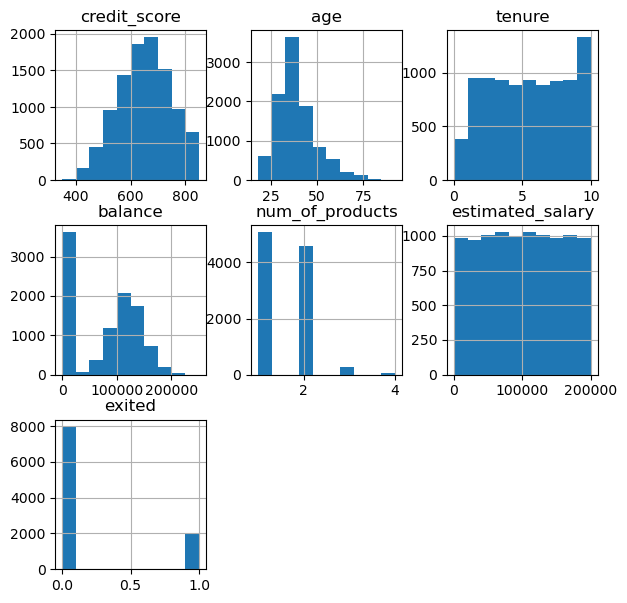

In [8]:
data.hist(figsize=(7, 7),bins=10);

In [9]:
data.describe()

,credit_score,age,tenure,balance,num_of_products,estimated_salary,exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000,1.000000


Let's see how the share of clients is distributed by country, and what share of clients left the bank:

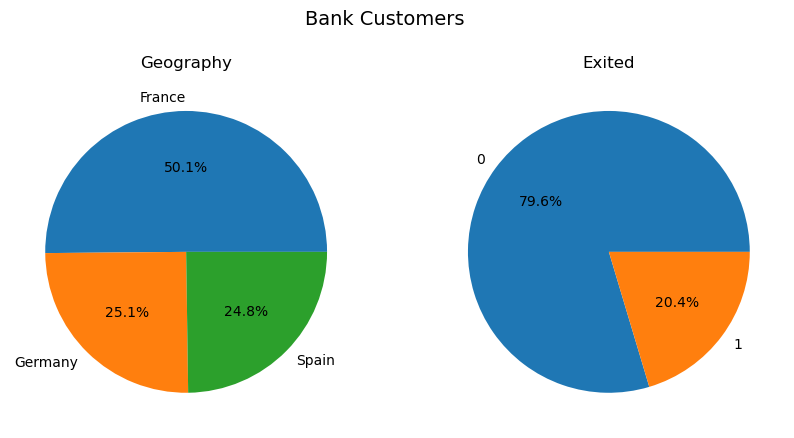

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data['geography'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[0])
axs[0].set_title('Geography')
data['exited'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[1])
axs[1].set_title('Exited')

fig.suptitle('Bank Customers', fontsize=14)

for ax in axs:
    ax.axis('off')
plt.show()

The charts show that 50% of customers are from France, and the share of those who leave is 20%. Let us determine the features that most affect the departure of customers from banks

In [11]:
data.corr()

,credit_score,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_credit_card,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


The most correlated attribute with `exit` is the age of the clients, and the presence of a credit card has the least effect. In addition, we will check which countries and genders more often left the bank:

In [12]:
geography = data.pivot_table(index='geography', values='exited', aggfunc=['count', 'mean'])
geography.columns = ('count', 'mean')
geography

,count,mean
geography,,
France,5014,0.161548
Germany,2509,0.324432
Spain,2477,0.166734


In [13]:
gender = data.pivot_table(index='gender', values='exited', aggfunc=['count', 'mean'])
gender.columns = ('count', 'mean')
gender

,count,mean
gender,,
Female,4543,0.250715
Male,5457,0.164559


Residents of Germany left the bank more often (32.4%). Residents of Spain (16.1%) and France (16.7%) were equally likely to leave the bank. It also follows from the data that women left the bank more often than men. Now let us consider the most correlated feature with `exit` - age:

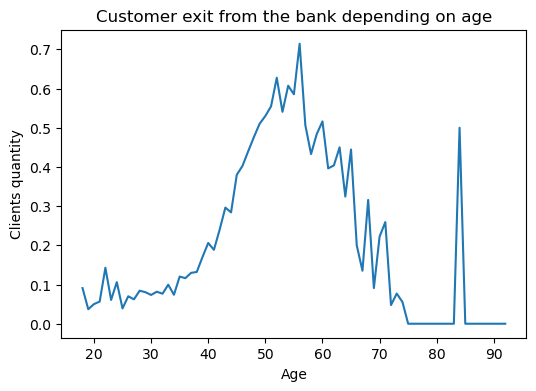

In [14]:
age = data.groupby('age')['exited'].mean()
age.plot(figsize = (6,4))
plt.xlabel('Age')
plt.ylabel('Clients quantity')
plt.title('Customer exit from the bank depending on age');

The graph clearly shows that older people (over 45 years) more often leave the bank, it is also worth noting the peak of leaving the banks at the age of 85 years.

let's change the type of data `tenure` column to the categorical features (the missing values will be separate, because it is illogical to replace them with anything; it is unknown for what reason these missing values were made):

In [15]:
data['tenure'] = data['tenure'].astype('object')

Output the data after all the changes:

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   object 
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_credit_card   10000 non-null  bool   
 8   is_active_member  10000 non-null  bool   
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: bool(2), float64(2), int64(4), object(3)
memory usage: 722.8+ KB


In [17]:
data.describe()

,credit_score,age,balance,num_of_products,estimated_salary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.889288,1.530200,100090.239881,0.203700
std,96.653299,10.487806,62397.405202,0.581654,57510.492818,0.402769
min,350.000000,18.000000,0.000000,1.000000,11.580000,0.000000
25%,584.000000,32.000000,0.000000,1.000000,51002.110000,0.000000
50%,652.000000,37.000000,97198.540000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,127644.240000,2.000000,149388.247500,0.000000
max,850.000000,92.000000,250898.090000,4.000000,199992.480000,1.000000


**Conclusion:**
- no duplicates were found in the data, but there are missing values in the 'tenure' column
- the sample presents data in which 79.6% of customers remain customers of the bank, and 20.4% of customers have left the bank
- Bank customers are predominantly from France (50.1%), Germany (25.1%) and Spain (24.8%)
- the information contained in the attributes of columns 'row_number', 'customer_id' and 'surname' is not useful for us in building models, so we got rid of these columns

## 2 Исследование задачи

Display the distribution of data in `exited` as a table:

In [18]:
data['exited'].value_counts()/len(data['exited'])*100

0    79.63
1    20.37
Name: exited, dtype: float64

20% of customers left the bank, 80% remain customers of the bank. The classes are not balanced. We divide the data into training, validation, and test samples (3:1:1, 60% training sample and 20% validation and test samples):

In [19]:
data_train, data_train_one = train_test_split(data, test_size=0.4, random_state=12345)
data_test, data_valid = train_test_split(data_train_one, test_size=0.5, random_state=12345)

Let's check the sample sizes:

In [20]:
print(f'Training sample size: {len (data_train) / len(data):.0%}')
print(f'Validation sample size: {len (data_valid) / len(data):.0%}')
print(f'Test sample size: {len (data_test) / len(data):.0%}')

Training sample size: 60%
Validation sample size: 20%
Test sample size: 20%


Let's convert the categorical features by direct coding:

In [21]:
data_train = pd.get_dummies(data_train, drop_first=True)
data_valid = pd.get_dummies(data_valid, drop_first=True)
data_test = pd.get_dummies(data_test, drop_first=True)

C:\Users\Julia\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\Julia\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\Julia\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Let's save the features and the target feature (exited) in the variables:

In [22]:
target_train = data_train['exited']
features_train = data_train.drop('exited', axis=1)
target_valid = data_valid['exited']
features_valid = data_valid.drop('exited', axis=1)
target_test = data_test['exited']
features_test = data_test.drop('exited', axis=1)

Now let's apply scaling using the StandardScaler method to the numeric attributes `credit_score`, `age`, `balance`, `estimated_salary`:

In [23]:
numeric = ['credit_score', 'age', 'balance', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

The data contained in the `exited` attribute are categorical, we will use classification models. At this point we will train the models without considering class imbalances. 

Consider DecisionTreeClassifier. Let's allocate hyperparameters for tuning the decision tree: `max_depth`, `min_sample_leaf`. We use `f1_score` and `roc_auc` to check the quality of the model.

In [24]:
best_depth = 0
best_leaf = 0
best_f1 = 0
for depth in range(2,16):
    for leaf in range(2,10):
        model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf)
        model_dt.fit(features_train, target_train)
        predictions_valid_dt = model_dt.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid_dt)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_leaf = leaf
print('F1 best model:', best_f1)
print('Max depth:', best_depth)
print('Min samples leaf', best_leaf)

F1 best model: 0.5541838134430728
Max depth: 10
Min samples leaf 8


In [25]:
probabilities_valid = model_dt.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', roc_auc)

AUC-ROC: 0.7963897396229187


`F1` is 0.55, which is not enough for the target of 0.59. We additionally calculated `roc_auc`, which is 0.80.

Consider LogisticRegression. Let's allocate hyperparameters for tuning the decision tree: `solver` and `max_iter`. We use `f1_score` and `roc_auc_score` to check the quality of the model.

In [26]:
best_f1_lr = 0
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(features_train, target_train)
predictions_valid_lr = model_lr.predict(features_valid)
f1_lr = f1_score(target_valid, predictions_valid_lr)
if f1_lr > best_f1_lr:
    best_f1_lr = f1_lr
print('F1 best model:', best_f1_lr)

F1 best model: 0.2777777777777778


In [27]:
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', roc_auc)

AUC-ROC: 0.7374042643136938


`F1` of the logistic regression is significantly lower than the decision tree model and is equal to 0.27, additionally we calculated `roc_auc`, which is also lower and is equal to 0.74

Consider RandomForestClassifier. We use `f1_score` and `roc_auc_score` to check the quality of the model.

In [28]:
best_depth_rf = 0
best_estimator_rf = 0
best_f1_rf = 0
for depth in range(2,25):
    for estimator in range(40,120,10):
        model_rf = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, min_samples_leaf=5)
        model_rf.fit(features_train, target_train)
        predictions_valid_rf = model_rf.predict(features_valid)
        f1_rf = f1_score(target_valid, predictions_valid_rf)
        if f1_rf > best_f1_rf:
            best_f1_rf = f1_rf
            best_depth_rf = depth
            best_estimator_rf = estimator
print('F1 best model:', best_f1_rf)
print('Max depth:', best_depth_rf)
print('Number of estimators:', best_estimator_rf)

F1 best model: 0.5150078988941549
Max depth: 18
Number of estimators: 40


In [29]:
probabilities_valid = model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', roc_auc)

AUC-ROC: 0.8566719284753795


The `F1` of the random forest is equal to 0.51, which is almost equal to the result of the decision tree and also not enough to the target indicator, additionally counted `roc_auc`, which is equal to 0.88.


**Conclusion:** the best result on the unbalanced sample was shown by the RandomForestClassifier (f1 0.51, roc_auc 0.86) and DecisionTreeClassifier(f1 0.55, roc_auc 0.80) models. The worst result was shown by the logistic regression model with f1 equal to 0.27 and roc_auc 0.73. In what follows we will consider the two most successful models.

Let's improve the results of the metrics with class balancing.

## 3 Solving the imbalance problem

To solve the imbalance problem, we will weigh the classes on decision tree and random forest models, perhaps this will increase the f1 and roc_auc:

In [30]:
best_depth = 0
best_leaf = 0
best_f1 = 0
for depth in range(2,16):
    for leaf in range(2,20):
        model_balanced_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf,
                                                   class_weight='balanced')
        model_balanced_dt.fit(features_train, target_train)
        predicted_valid_balanced_dt = model_balanced_dt.predict(features_valid)
        f1_balanced = f1_score(target_valid, predicted_valid_balanced_dt)
        if f1_balanced > best_f1:
            best_f1 = f1_balanced
            best_depth = depth
            best_leaf = leaf
print('Decision Tree')            
print('F1 of the best model on a balanced sample:', best_f1)
print('Max depth:', best_depth)
print('Min samples leaf:', best_leaf)

Decision Tree
F1 of the best model on a balanced sample: 0.5968688845401174
Max depth: 7
Min samples leaf: 17


In [31]:
probabilities_balanced_valid = model_balanced_dt.predict_proba(features_valid)
probabilities_one_balanced_valid = probabilities_balanced_valid[:, 1]
roc_auc_balanced_dt = roc_auc_score(target_valid, probabilities_one_balanced_valid)
print('AUC-ROC:', roc_auc_balanced_dt)

AUC-ROC: 0.8209448469503247


In [32]:
best_depth_rf = 0
best_estimator_rf = 0
best_f1_rf = 0
for depth in range(2,25):
    for estimator in range(40,120,10):
        model_balanced_rf = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, 
                                                   min_samples_leaf=5, class_weight='balanced')
        model_balanced_rf.fit(features_train, target_train)
        predicted_valid_balanced_rf = model_balanced_rf.predict(features_valid)
        f1_rf_balanced = f1_score(target_valid, predicted_valid_balanced_rf)
        if f1_rf_balanced > best_f1_rf:
            best_f1_rf = f1_rf_balanced
            best_depth_rf = depth
            best_estimator_rf = estimator
print('Random Forest')
print('F1 of the best model on a balanced sample:', best_f1_rf)
print('Max depth:', best_depth_rf)
print('Number of estimators:', best_estimator_rf)

Random Forest
F1 of the best model on a balanced sample: 0.6252873563218392
Max depth: 19
Number of estimators: 70


In [33]:
probabilities_balanced_valid_rf = model_balanced_rf.predict_proba(features_valid)
probabilities_one_balanced_valid_rf = probabilities_balanced_valid_rf[:, 1]
roc_auc_balanced_rf = roc_auc_score(target_valid, probabilities_one_balanced_valid_rf)
print('AUC-ROC:', roc_auc_balanced_rf)

AUC-ROC: 0.8545597095361662


Class weighting increased the results of the decision tree model metrics (F1 0.60 , roc_auc 0.82), and the results of the random forest (f1 0.62, roc_auc 0.84)

Let's balance the sample with over-sampling and under-sampling, and calculate the F1 value and roc_auc for the decision tree and random forest models:

In [34]:
features_oversampled, target_oversampled = SMOTE(random_state=123).fit_resample(features_train, target_train)
target_oversampled.value_counts()

0    4804
1    4804
Name: exited, dtype: int64

**Decision Tree:**

In [35]:
best_depth = 0
best_leaf = 0
best_f1 = 0
for depth in range(2,16):
    for leaf in range(2,20):
        model_oversampled_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf, 
                                                      class_weight = 'balanced')
        model_oversampled_dt.fit(features_oversampled, target_oversampled)
        predicted_valid_oversampled_dt = model_oversampled_dt.predict(features_valid)
        f1_oversampled = f1_score(target_valid, predicted_valid_oversampled_dt)
        if f1_oversampled > best_f1:
            best_f1 = f1_oversampled
            best_depth = depth
            best_leaf = leaf
print('Decision Tree oversample')            
print('F1 of the best model on a balanced sample:', best_f1)
print('Max depth:', best_depth)
print('Min samples leaf:', best_leaf)

Decision Tree oversample
F1 of the best model on a balanced sample: 0.5781710914454278
Max depth: 6
Min samples leaf: 11


In [36]:
probabilities_oversampled_valid = model_oversampled_dt.predict_proba(features_valid)
probabilities_one_oversampled_valid = probabilities_oversampled_valid[:, 1]
roc_auc_oversampled_dt = roc_auc_score(target_valid, probabilities_one_oversampled_valid)
print('AUC-ROC:', roc_auc_oversampled_dt)

AUC-ROC: 0.797063580938161


**Random Forest:**

In [37]:
best_depth_rf = 0
best_estimator_rf = 0
best_f1_rf = 0
for depth in range(2,25):
    for estimator in range(40,120,10):
        model_oversampled_rf = RandomForestClassifier(random_state=12345, n_estimators=estimator, max_depth=depth,
                                                      min_samples_leaf=5, class_weight = 'balanced')
        model_oversampled_rf.fit(features_oversampled, target_oversampled)
        predicted_valid_oversampled_rf = model_oversampled_rf.predict(features_valid)
        f1_rf_oversampled = f1_score(target_valid, predicted_valid_oversampled_rf)
        if f1_rf_oversampled > best_f1_rf:
            best_f1_rf = f1_rf_oversampled
            best_depth_rf = depth
            best_estimator_rf = estimator
print('Random Forest oversample')
print('F1 of the best model on a balanced sample:', best_f1_rf)
print('Max depth:', best_depth_rf)
print('Number of estimators:', best_estimator_rf)

Random Forest oversample
F1 of the best model on a balanced sample: 0.6178343949044586
Max depth: 11
Number of estimators: 70


In [38]:
probabilities_oversampled_valid_rf = model_oversampled_rf.predict_proba(features_valid)
probabilities_one_oversampled_valid_rf = probabilities_oversampled_valid_rf[:, 1]
roc_auc_oversampled_rf = roc_auc_score(target_valid, probabilities_one_oversampled_valid_rf)
print('AUC-ROC:', roc_auc_oversampled_rf)

AUC-ROC: 0.8459969028784041


In [39]:
random_undersampler = RandomUnderSampler()
features_undersampled, target_undersampled = random_undersampler.fit_resample(features_train, target_train)
target_undersampled.value_counts()

0    1196
1    1196
Name: exited, dtype: int64

**Decision Tree:**

In [40]:
best_depth = 0
best_leaf = 0
best_f1 = 0
for depth in range(2,16):
    for leaf in range(2,20):
        model_undersampled_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf, 
                                                      class_weight = 'balanced')
        model_undersampled_dt.fit(features_undersampled, target_undersampled)
        predicted_valid_undersampled_dt = model_undersampled_dt.predict(features_valid)
        f1_undersampled = f1_score(target_valid, predicted_valid_undersampled_dt)
        if f1_undersampled > best_f1:
            best_f1 = f1_undersampled
            best_depth = depth
            best_leaf = leaf
print('Decision Tree undersample')            
print('F1 of the best model on a balanced sample:', best_f1)
print('Max depth:', best_depth)
print('Min samples leaf:', best_leaf)

Decision Tree undersample
F1 of the best model on a balanced sample: 0.6020066889632107
Max depth: 5
Min samples leaf: 8


In [41]:
probabilities_undersampled_valid = model_undersampled_dt.predict_proba(features_valid)
probabilities_one_undersampled_valid = probabilities_undersampled_valid[:, 1]
roc_auc_undersampled_dt = roc_auc_score(target_valid, probabilities_one_undersampled_valid)
print('AUC-ROC:', roc_auc_undersampled_dt)

AUC-ROC: 0.8313972575632878


Случайный лес:

In [42]:
best_depth_rf = 0
best_estimator_rf = 0
best_f1_rf = 0
for depth in range(2,25):
    for estimator in range(40,120,10):
        model_undersampled_rf = RandomForestClassifier(random_state=12345, n_estimators=estimator, max_depth=depth,
                                                      min_samples_leaf=5, class_weight = 'balanced')
        model_undersampled_rf.fit(features_undersampled, target_undersampled)
        predicted_valid_undersampled_rf = model_undersampled_rf.predict(features_valid)
        f1_rf_undersampled = f1_score(target_valid, predicted_valid_undersampled_rf)
        if f1_rf_undersampled > best_f1_rf:
            best_f1_rf = f1_rf_undersampled
            best_depth_rf = depth
            best_estimator_rf = estimator
print('Random Forest undersample')
print('F1 of the best model on a balanced sample:', best_f1_rf)
print('Max depth:', best_depth_rf)
print('Number of estimators:', best_estimator_rf)

Random Forest undersample
F1 of the best model on a balanced sample: 0.5990783410138248
Max depth: 6
Number of estimators: 70


In [43]:
probabilities_undersampled_valid_rf = model_undersampled_rf.predict_proba(features_valid)
probabilities_one_undersampled_valid_rf = probabilities_undersampled_valid_rf[:, 1]
roc_auc_undersampled_rf = roc_auc_score(target_valid, probabilities_one_undersampled_valid_rf)
print('AUC-ROC:', roc_auc_undersampled_rf)

AUC-ROC: 0.8527727933008631


**Conclusion:**
- with class weighting (class_weight='balanced') we managed to achieve the required results of decision tree model metrics (F1 0.59 , roc_auc 0.82), and results of random forest (f1 0.625, roc_auc 0.85)
- by increasing classes, the results of the decision tree metrics are slightly worse (F1 0.58 , roc_auc 0.80), and the results of the random forest are about the same as for weighting (f1 0.617, roc_auc 0.84)
- with class reduction, the results of the decision tree metrics are slightly worse (F1 0.60 , roc_auc 0.83), and the results of the random forest are about the same as with weighting (f1 0.60, roc_auc 0.84)
- The best results of F1 metric are obtained for the random forest model in the balanced sample (class_weight='balanced') (f1 0.62, roc_auc 0.85)

We will test the random forest model because its accuracy f1 is higher than that of the decision tree. However, it is worth noting that the random forest model is slightly inferior to the decision tree model in terms of speed.

## 4 Model testing

Let's test the random forest model with balanced classes (class_weight='balanced') calculated earlier, and additionally calculate metrics f1 and roc_auc on the test sample

In [44]:
model_balanced_rf.fit(features_train, target_train)
predicted_test_rf = model_balanced_rf.predict(features_test)
print('Random Forest')
print('F1 on the test sample:', f1_score(target_test, predicted_test_rf))
print('Roc_auc on the test sample:', roc_auc_score(target_test, predicted_test_rf))

Random Forest
F1 on the test sample: 0.6394557823129251
Roc_auc on the test sample: 0.7797984502688742


Let's construct a roc-curve and a confusion matrix

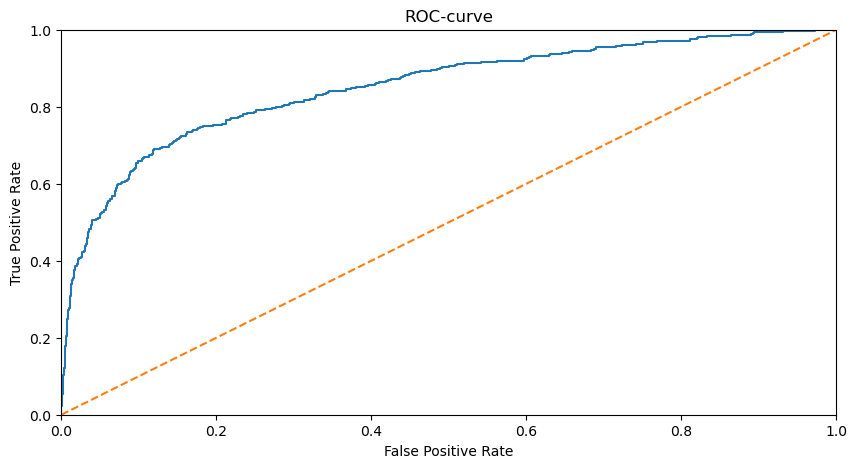

In [45]:
fpr, tpr, thresholds = roc_curve(target_test, model_balanced_rf.predict_proba(features_test)[:,1], pos_label=1)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

Text(0.5, 1.0, 'Confusion matrix')

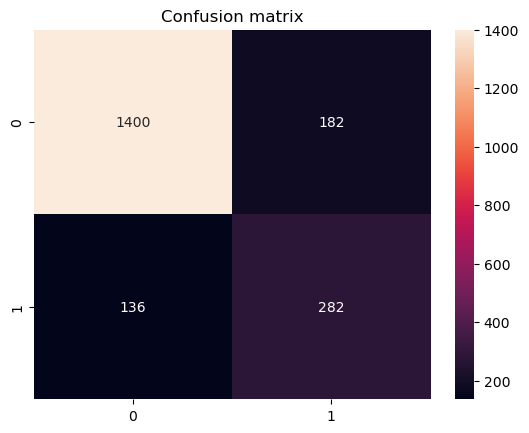

In [46]:
sbrn.heatmap(confusion_matrix(target_test, predicted_test_rf), annot=True, fmt='3.0f')
plt.title('Confusion matrix')

Let's check the result with the constant dummy model:

In [47]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
print('F1:', f1_score(dummy_model.predict(features_test), target_test))

F1: 0.3457402812241522


**Conclusion:** f1 score on the random forest test model gave a result of 0.639, auc_roc 0.779. The Roc-curve and confusion matrix showed good results, which means that the model predicted not randomly and answered correctly more often.

**General conclusion:**
- we were able to achieve an f1 metric result of 0.639, which is higher than the minimum threshold of 0.59
- the sample presents data in which 79.6% of customers continue to be customers of the bank, and 20.4% of customers have left the bank
- bank customers are residents of France (50.1%), Germany (25.1%) and Spain (24.8%)
- we applied scaling to numerical attributes and used a direct coding method to transform categorical attributes
- RandomForestClassifier (f1 0.51, roc_auc 0.86) and DecisionTreeClassifier(f1 0.55, roc_auc 0.80) models showed the best result on the unbalanced sample. The worst result was shown by the logistic regression model with f1 equal to 0.27 and roc_auc 0.73. Subsequently, the two most successful models were considered
- by weighting classes (class_weight='balanced') we were able to achieve the desired results of decision tree model metrics (F1 0.59 , roc_auc 0.82), and random forest results (f1 0.625, roc_auc 0.85)
- by increasing classes, the results of the decision tree metrics are slightly worse (F1 0.58 , roc_auc 0.80), and the results of the random forest are about the same as for weighting (f1 0.617, roc_auc 0.84)
- with class reduction, the results of the decision tree metrics are slightly worse (F1 0.60 , roc_auc 0.83), and the results of the random forest are about the same as with weighting (f1 0.60, roc_auc 0.84)
- The best F1 metric results were obtained by the random forest model on a balanced sample when weighting classes (class_weight='balanced') (f1 0.62 , roc_auc 0.85)
- The f1 score on the test random forest model yielded a score of 0.639, auc_roc 0.779. The Roc-curve and confusion matrix showed good results, which means that the model predicted not randomly and answered correctly more often.